In [1]:
import os

# List all files in the dataset directory
base_path = '/kaggle/input/actigraphydata/CleanedActigraphyData.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the training data
train = pd.read_csv(base_path)
train.head(5)

,participant_id,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,activity_level,sii
0,00115b9f,0.020411,0.001761,0.022853,0.018667,1.020398,0.001759,0.000000,0.000000,Medium,1.0
1,001f3379,0.013445,0.031016,2.952888,0.000000,0.996000,0.049507,3.763106,48.399446,Medium,1.0
2,00f332d1,0.029802,0.104216,3.681586,0.000000,0.980751,0.070811,15.596860,11.175805,Low,1.0
3,01085eb3,0.035465,0.085573,2.506849,0.000000,0.969044,0.082127,4.349319,0.000000,Low,0.0
4,012cadd8,0.061621,0.202441,6.307294,0.000000,0.966942,0.135903,8.530412,0.000000,Low,0.0


In [2]:
# Drop rows with specific participant IDs
train = train[~train['participant_id'].isin(['ab16a20d', 'db38d1f9'])]

# Check the dataset after removing the rows
train.head()


,participant_id,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,activity_level,sii
0,00115b9f,0.020411,0.001761,0.022853,0.018667,1.020398,0.001759,0.000000,0.000000,Medium,1.0
1,001f3379,0.013445,0.031016,2.952888,0.000000,0.996000,0.049507,3.763106,48.399446,Medium,1.0
2,00f332d1,0.029802,0.104216,3.681586,0.000000,0.980751,0.070811,15.596860,11.175805,Low,1.0
3,01085eb3,0.035465,0.085573,2.506849,0.000000,0.969044,0.082127,4.349319,0.000000,Low,0.0
4,012cadd8,0.061621,0.202441,6.307294,0.000000,0.966942,0.135903,8.530412,0.000000,Low,0.0


In [3]:
# Drop the 'activity_level' column as it was introduced to understand the data
train = train.drop(columns=['activity_level','participant_id'])

Normalization and Standardization:
Normalize features to a uniform scale (e.g., MinMaxScaler or StandardScaler).

ROC AUC Score (One-vs-Rest): 0.6458223204622839
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.50      0.56       117
         1.0       0.32      0.11      0.17        53
         2.0       0.12      0.15      0.14        27
         3.0       0.00      0.00      0.00         2

    accuracy                           0.34       199
   macro avg       0.27      0.19      0.22       199
weighted avg       0.48      0.34      0.39       199

Confusion Matrix:
 [[58 10 16 33]
 [21  6 10 16]
 [11  3  4  9]
 [ 0  0  2  0]]


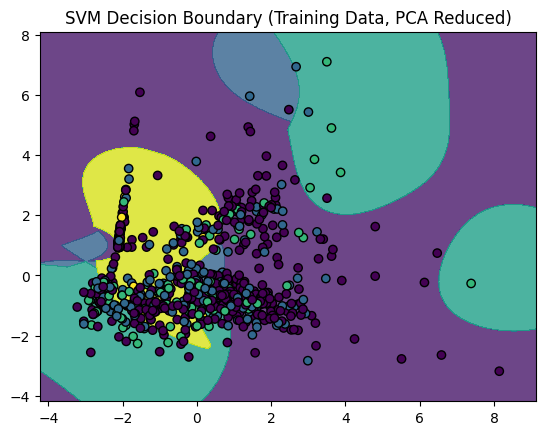

In [4]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import label_binarize


# Assuming data is already cleaned and preprocessed
X = train.drop(columns=[ 'sii'])
y = train['sii']

# Normalize/Standardize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42, stratify=y)

# PCA: Fit on the training data and transform both train and test sets
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Fit and transform on training data
X_test_pca = pca.transform(X_test)       # Transform test data using the same PCA object

# Train SVM on PCA-reduced training data
svm_model_pca = SVC(
    kernel='rbf', 
    C=1.0, 
    gamma='scale', 
    probability=True, 
    class_weight='balanced'
)
svm_model_pca.fit(X_train_pca, y_train)

# Predictions
y_pred = svm_model_pca.predict(X_test_pca)
y_prob = svm_model_pca.predict_proba(X_test_pca)  # Predicted probabilities for ROC-AUC

# Convert target to one-hot encoding for multi-class ROC-AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_prob_binarized = y_prob

# Compute ROC AUC Score for multi-class
roc_auc = roc_auc_score(y_test_binarized, y_prob_binarized, multi_class='ovr')
print("ROC AUC Score (One-vs-Rest):", roc_auc)

# Evaluation Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot decision boundary for training data
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap="viridis")
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap="viridis")
    plt.title(title)
    plt.show()

# Visualize decision boundary for training data
plot_decision_boundary(X_train_pca, y_train, svm_model_pca, "SVM Decision Boundary (Training Data, PCA Reduced)")
